In [1]:
%load_ext Cython

In [2]:
%%cython

import numpy as np
cimport numpy as np
import cython

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import pickle

# Input plot

In [5]:
with open('tests/timestream/ground_template_filter_array_input.pkl', 'rb') as f:
    ground_template_filter_array_input = pickle.load(f, encoding='latin1')
with open('tests/timestream/ground_template_filter_array_output.pkl', 'rb') as f:
    ground_template_filter_array_output = pickle.load(f, encoding='latin1')

In [6]:
input_array, az, mask, pixel_size, groundmap, lr, filtmask = ground_template_filter_array_input

In [7]:
input_array.shape

(1, 10508)

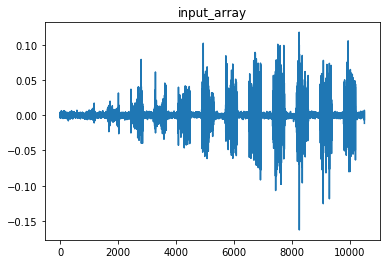

In [8]:
plt.title('input_array')
plt.plot(input_array[0])

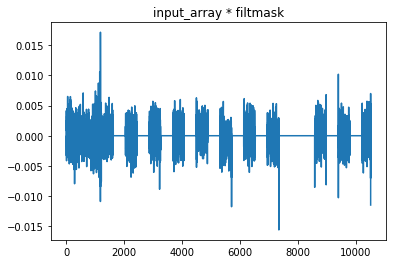

In [9]:
plt.title('input_array * filtmask')
plt.plot(input_array[0] * filtmask[0])

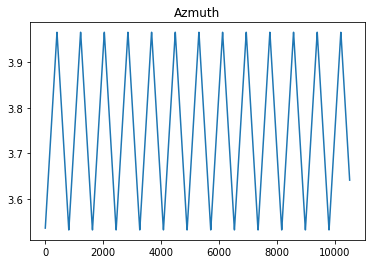

In [10]:
plt.title('Azmuth')
plt.plot(az)

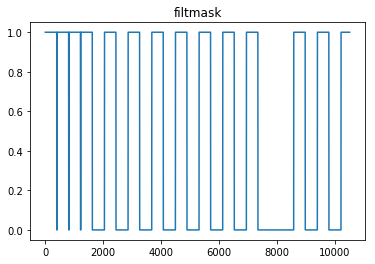

In [11]:
plt.title('filtmask')
plt.plot(filtmask[0])

# Output

# Code

In [12]:
%%cython --annotate

import numpy as np
cimport numpy as np
import cython

from cython.view cimport array as cvarray
from cpython cimport bool

from libc.math cimport round
from libc.stdlib cimport malloc, free

@cython.boundscheck(False)
@cython.wraparound(False)
cdef inline double max(double[:] x):
    cdef double max = x[0]
    for i in range(1, x.shape[0]):
        if x[i] > max:
            max = x[i]
    return max

@cython.boundscheck(False)
@cython.wraparound(False)
cdef inline double min(double[:] x):
    cdef double min = x[0]
    for i in range(1, x.shape[0]):
        if x[i] < min:
            min = x[i]
    return min

# @cython.boundscheck(False)
# @cython.wraparound(False)
# @cython.cdivision(True)
def ground_template_filter_array(
        double[:, :] input_array,
        double[:] az,
        np.ndarray[np.uint8_t, cast=True, ndim=2] mask,
        double pixel_size,
        bool groundmap=False,
        bool lr=False,
        np.ndarray[np.uint8_t, cast=True, ndim=2] filtmask=None):
    '''
    Remove ground template from array timestreams

    Parameters
    ----------
    input_array: array_like
        shape: (number of channels, number of time steps)
        Input timestream, mutated inplace.
    az: array_like
        shape: input_array[0]
        The azimuth of the timestream.
    mask: array_like
        shape: input_array
        dtype: bool
    pixel_size: float
    groundmap: bool
        If groundmap = True, then do the exact opposite,
        and remove component from timestream that isn't fixed with the ground
    lr: bool
        If true, ground substraction done separately on left and right moving scans
    filtmask: array_like
        shape: input_array
        dtype: bool
        default: None
        filtmask is preprocessed from mask and addtional masking e.g. from point source
        In largepatch filtmask refers to wafermask_chan_filt
    '''
    # initialize
    if filtmask is not None:
        mask = filtmask
    cdef int nCh = input_array.shape[0]
    cdef int nTime = input_array.shape[1]
    cdef double az_min = min(az)
    cdef double az_range = max(az) - az_min
    # Calculate number of pixels given the pixel size
    cdef int nPix = <int>round(az_range / pixel_size)

    # get pointing: an array where each elements is the n-th bin
    # beaware of the (n+1)-th bin that needs to be dealt with separately
    cdef Py_ssize_t* pointing = <Py_ssize_t*>malloc(nTime * sizeof(Py_ssize_t))
#     pointing_init = cvarray(shape=(nTime,), itemsize=sizeof(Py_ssize_t), format="i")
#     cdef Py_ssize_t[:] pointing = pointing_init
    cdef double nPix_per_range = nPix / az_range
    for i in range(nTime):
        # possible values: [0, 1, ..., nPix]
        pointing[i] = <Py_ssize_t>((az[i] - az_min) * nPix_per_range)

    # bins are arrays of pixels
    cdef int nBin = nPix + 1
    # the signal
#     bins_signal = cvarray(shape=(nCh, nBin), itemsize=sizeof(double), format="i")
#     bins_signal[...] = 0
#     # number of hits of signals
#     bins_hit = cvarray(shape=(nCh, nBin), itemsize=sizeof(int), format="i")
#     bins_hit[...] = 0
    bins_signal_init = np.zeros((nCh, nBin))
    cdef double [:, :] bins_signal = bins_signal_init
    # number of hits of signals
    bins_hit_init = np.zeros((nCh, nBin), dtype=np.int32)
    cdef int [:, :] bins_hit = bins_hit_init

    cdef Py_ssize_t k
    if not lr:
        # calculate ground template
        for i in range(nCh):
            for j in range(nTime):
                if mask[i, j]:
                    k = pointing[j]
                    bins_signal[i, k] += input_array[i, j]
                    bins_hit[i, k] += 1
        for i in range(nCh):
            bins_signal[i, nBin - 2] += bins_signal[i, nBin - 1]
            bins_hit[i, nBin - 2] += bins_hit[i, nBin - 1]
            for j in range(nPix):
                if bins_hit[i, j] != 0:
                    bins_signal[i, j] /= bins_hit[i, j]
        # substraction
        for i in range(nCh):
            for j in range(nTime):
                k = pointing[j]
                input_array[i, j] -= bins_signal[i, k]

#     free(pointing)

# Tests

In [13]:
import numpy as np
from numpy.testing import assert_allclose

def assertIdenticalList(list1, list2):
    for i, list1i in enumerate(list1):
        if isinstance(list1i, bool):
            assert list1i is list2[i]
        else:
            assert_allclose(list1i, list2[i], rtol=1e-03)

In [14]:
import pickle
import sys
py2 = sys.version_info[0] == 2


def test_ground_template_filter_array():
    with open('tests/timestream/ground_template_filter_array_input.pkl', 'rb') as f:
        if not py2:
            ground_template_filter_array_input = pickle.load(
                f, encoding='latin1')
        else:
            ground_template_filter_array_input = pickle.load(f)
    with open('tests/timestream/ground_template_filter_array_output.pkl', 'rb') as f:
        if not py2:
            ground_template_filter_array_output = pickle.load(
                f, encoding='latin1')
        else:
            ground_template_filter_array_output = pickle.load(f)
    ground_template_filter_array(*ground_template_filter_array_input)
    assertIdenticalList(
        ground_template_filter_array_input,
        ground_template_filter_array_output)

    # debug
    return ground_template_filter_array_input, ground_template_filter_array_output

In [15]:
test_ground_template_filter_array()

((array([[ 0.        ,  0.0032052 ,  0.00404837, ..., -0.0070533 ,
           0.00699448, -0.01087422]]),
  array([ 3.53594566,  3.53711146,  3.53820095, ...,  3.64341665,
          3.64234824,  3.64129303]),
  array([[ True,  True,  True, ...,  True,  True,  True]], dtype=bool),
  0.0013962634015954637,
  False,
  False,
  array([[ True,  True,  True, ...,  True,  True,  True]], dtype=bool)),
 (array([[ 0.        ,  0.0032052 ,  0.00404837, ..., -0.0070533 ,
           0.00699448, -0.01087422]]),
  array([ 3.53594566,  3.53711146,  3.53820095, ...,  3.64341665,
          3.64234824,  3.64129303]),
  array([[ True,  True,  True, ...,  True,  True,  True]], dtype=bool),
  0.0013956848012076121,
  False,
  False,
  array([[ True,  True,  True, ...,  True,  True,  True]], dtype=bool)))

# Playground

In [16]:
output_array = input_array.copy()

In [17]:
%%timeit
ground_template_filter_array(output_array, az, mask, pixel_size)

10000 loops, best of 3: 92 µs per loop


In [18]:
output_array = input_array.copy()
ground_template_filter_array(output_array, az, mask, pixel_size)

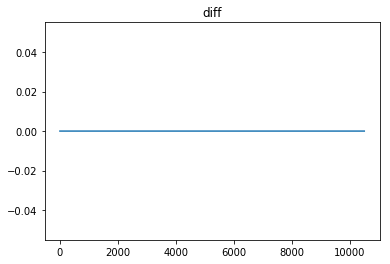

In [19]:
plt.title('diff')
plt.plot(input_array[0] - input_array[0])

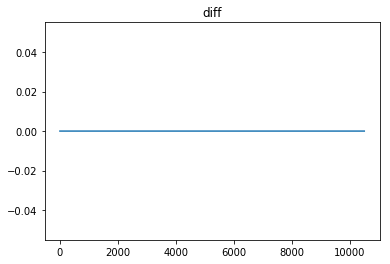

In [20]:
plt.title('diff')
plt.plot(output_array[0] - ground_template_filter_array_output[0][0])